In [1]:
import nltk
#nltk.download("all")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import gensim
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter("ignore")
 
%matplotlib inline  

### Data Preparation

In [2]:
### Loading Dataset: open json file as dataframe

## Import Data
url = "https://github.com/toheebadura/Sarcasm_Detection_Task/blob/main/Datasets/Sarcasm_Headlines_Dataset.json?raw=true"
df = pd.read_json(url, lines=True)
df.drop(['article_link'], axis=1, inplace=True)
df["is_sarcastic"] = df["is_sarcastic"].map({0: "Non-Sarcastic", 1: "Sarcastic"})
print(df.shape)
df.head()

(26709, 2)


,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,Non-Sarcastic
1,the 'roseanne' revival catches up to our thorn...,Non-Sarcastic
2,mom starting to fear son's web series closest ...,Sarcastic
3,"boehner just wants wife to listen, not come up...",Sarcastic
4,j.k. rowling wishes snape happy birthday in th...,Non-Sarcastic


In [3]:
### Checking for missing values
print("Missing Values:")
print(df.isnull().sum())

print()
###Checking for shape
print(f"Shape of the Dataset: {df.shape}")

print()

###Checking for value counts
###Checking for sarcastic and non sarcastic
print(df["is_sarcastic"].value_counts())
print()
print(df["is_sarcastic"].value_counts(normalize=True))
print()
###Checking for duplicates
print(f"Number of Duplicates: {df.duplicated().sum()}")

Missing Values:
headline        0
is_sarcastic    0
dtype: int64

Shape of the Dataset: (26709, 2)

is_sarcastic
Non-Sarcastic    14985
Sarcastic        11724
Name: count, dtype: int64

is_sarcastic
Non-Sarcastic    0.561047
Sarcastic        0.438953
Name: proportion, dtype: float64

Number of Duplicates: 107


In [4]:
df["headline"].value_counts()

headline
sunday roundup                                                             10
the 20 funniest tweets from women this week                                10
'no way to prevent this,' says only nation where this regularly happens     8
the funniest tweets from parents this week                                  6
the funniest tweets from women this week                                    4
                                                                           ..
health inspector repulsed by restaurant's customers                         1
7 ways stand-up comedy can teach us to effectively motivate others          1
man's dream to get drunk in an a-frame finally realized                     1
eager understudy beginning to think john lithgow impervious to disease      1
gourmet gifts for the foodie 2014                                           1
Name: count, Length: 26602, dtype: int64

In [5]:
## Remove duplicates: if counts > 1
for i in df['headline'].value_counts()[df['headline'].value_counts() > 1].index:
    df.drop(df[df['headline'] == i].index, inplace=True)

df.shape

(26524, 2)

In [6]:
df["headline"].value_counts()

headline
former versace store clerk sues over secret 'black code' for minority shoppers         1
death to shoppers? al-shabaab and the fracturing of international jihadism             1
why father's day is so difficult for me                                                1
rise of walking for fun & fitness as a social trend                                    1
trump's whole approach to health care boiled down to one tweet                         1
                                                                                      ..
cnn renews 'this week at war' for next eight seasons                                   1
civil rights movement network law is a much-needed tool                                1
dianne feinstein eviscerates jeff sessions in savage closing argument                  1
new york attorney general examining eric trump charity payments to trump properties    1
gourmet gifts for the foodie 2014                                                      1
Name: count,

In [7]:
### Great! It's obvious that there are no duplicates
# Now, let's check the details again
### Checking for missing values
print("Missing Values:")
print(df.isnull().sum())

print()
###Checking for shape
print(f"Shape of the Dataset: {df.shape}")

print()

###Checking for value counts
###Checking for sarcastic and non sarcastic
print(df["is_sarcastic"].value_counts())
print()
print(df["is_sarcastic"].value_counts(normalize=True))
print()

###Checking for duplicates
print(f"Number of Duplicates: {df.duplicated().sum()}")

Missing Values:
headline        0
is_sarcastic    0
dtype: int64

Shape of the Dataset: (26524, 2)

is_sarcastic
Non-Sarcastic    14939
Sarcastic        11585
Name: count, dtype: int64

is_sarcastic
Non-Sarcastic    0.563226
Sarcastic        0.436774
Name: proportion, dtype: float64

Number of Duplicates: 0


In [8]:
### Save the dataset
df.to_csv("Sarcasm_Headlines_Dataset.csv", index=False, header=True)

In [9]:
### Load the dataset
df = pd.read_csv("Sarcasm_Headlines_Dataset.csv")
print(df.shape)
df.head()

(26524, 2)


,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,Non-Sarcastic
1,the 'roseanne' revival catches up to our thorn...,Non-Sarcastic
2,mom starting to fear son's web series closest ...,Sarcastic
3,"boehner just wants wife to listen, not come up...",Sarcastic
4,j.k. rowling wishes snape happy birthday in th...,Non-Sarcastic


In [10]:
print(df["headline"].value_counts())

headline
former versace store clerk sues over secret 'black code' for minority shoppers         1
death to shoppers? al-shabaab and the fracturing of international jihadism             1
why father's day is so difficult for me                                                1
rise of walking for fun & fitness as a social trend                                    1
trump's whole approach to health care boiled down to one tweet                         1
                                                                                      ..
cnn renews 'this week at war' for next eight seasons                                   1
civil rights movement network law is a much-needed tool                                1
dianne feinstein eviscerates jeff sessions in savage closing argument                  1
new york attorney general examining eric trump charity payments to trump properties    1
gourmet gifts for the foodie 2014                                                      1
Name: count,

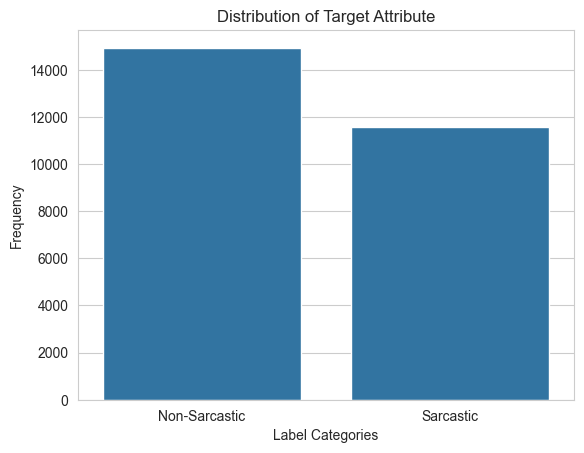

In [11]:
## checking the count of sarcastic and non sarcastic
sns.set_style("whitegrid")
##plotting the count of sarcastic and non sarcastic, and renaming the labels
sns.countplot(x="is_sarcastic", data=df)
sns.set(rc={'figure.figsize':(10,8)})
##Rename the labels
plt.xlabel("Label Categories")
plt.ylabel("Frequency")
plt.title("Distribution of Target Attribute");

#### Feature Engineering: Creating  features

In [12]:
import string
import nltk 
import re
#### Getting the length of each headline and adding it as a new column to the dataframe
df["body_len"] = df["headline"].apply(lambda x: len(x) - x.count(" ")) 
### Function to count the number of punctuations in each headline
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round((count/(len(text) - text.count(" "))), 3)*100    
df["punct_percent"] = df["headline"].apply(lambda x: count_punct(x)) 
### Function to get the number of words in each headline    
# def get_word_count(x):
#     return len(x.split())

df.head(10) 


,headline,is_sarcastic,body_len,punct_percent
0,former versace store clerk sues over secret 'b...,Non-Sarcastic,67,3.0
1,the 'roseanne' revival catches up to our thorn...,Non-Sarcastic,71,4.2
2,mom starting to fear son's web series closest ...,Sarcastic,66,1.5
3,"boehner just wants wife to listen, not come up...",Sarcastic,72,2.8
4,j.k. rowling wishes snape happy birthday in th...,Non-Sarcastic,54,3.7
5,advancing the world's women,Non-Sarcastic,24,4.2
6,the fascinating case for eating lab-grown meat,Non-Sarcastic,40,2.5
7,"this ceo will send your kids to school, if you...",Non-Sarcastic,54,1.9
8,top snake handler leaves sinking huckabee camp...,Sarcastic,44,0.0
9,friday's morning email: inside trump's presser...,Non-Sarcastic,51,5.9


In [13]:
print(df["punct_percent"].describe())

count    26524.000000
mean         2.167520
std          2.553836
min          0.000000
25%          0.000000
50%          1.700000
75%          3.500000
max         30.000000
Name: punct_percent, dtype: float64


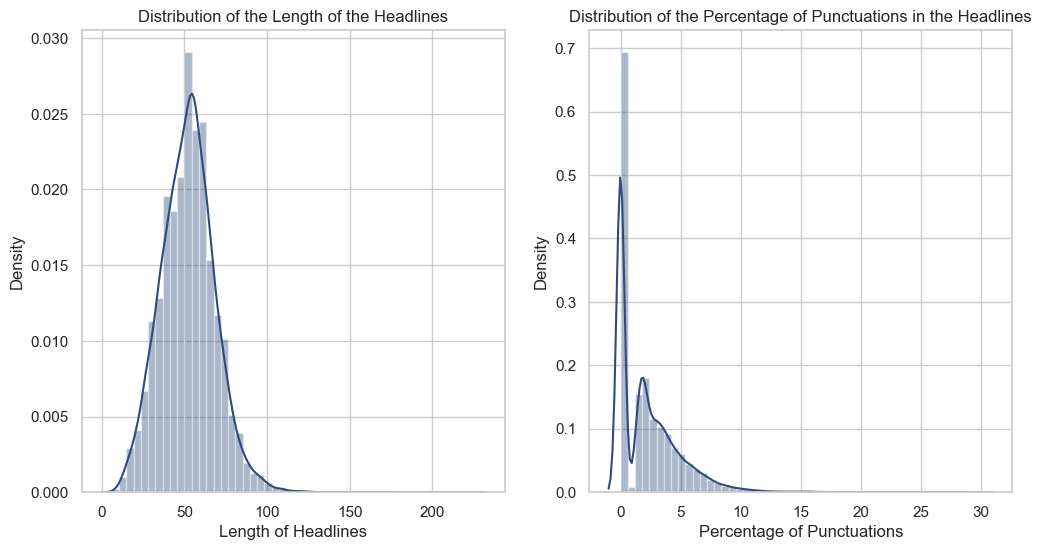

In [14]:
### Plotting the distribution of the length of the headlines and the percentage of punctuations in the headlines    
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))    
sns.distplot(df['body_len'], ax=ax1, color = "#2f4b7c") 
ax1.set_title('Distribution of the Length of the Headlines')  
ax1.set_xlabel('Length of Headlines')  
sns.distplot(df['punct_percent'], ax=ax2, color = "#2f4b7c")    
ax2.set_title('Distribution of the Percentage of Punctuations in the Headlines') 
ax2.set_xlabel('Percentage of Punctuations')     
plt.show()

In [15]:
#### Getting the average length of the headlines for each target class
df.groupby('is_sarcastic')['body_len'].mean()   


is_sarcastic
Non-Sarcastic    50.801593
Sarcastic        53.905999
Name: body_len, dtype: float64

#### Starting Again

In [16]:
### Load the dataset
df = pd.read_csv("Sarcasm_Headlines_Dataset.csv")
print(df.shape)
df.head()

(26524, 2)


,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,Non-Sarcastic
1,the 'roseanne' revival catches up to our thorn...,Non-Sarcastic
2,mom starting to fear son's web series closest ...,Sarcastic
3,"boehner just wants wife to listen, not come up...",Sarcastic
4,j.k. rowling wishes snape happy birthday in th...,Non-Sarcastic


In [17]:
## Change Labels with LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["is_sarcastic"] = le.fit_transform(df["is_sarcastic"])

df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [18]:
### Carrying Out Data Cleaning
english_stops = set(stopwords.words('english'))    
wn = WordNetLemmatizer()    
ps = PorterStemmer()    


### data cleaning function

def cleaning(text):
  text = "".join([word.lower() for word in text if word not in string.punctuation])
  tokens = re.split("\W+", text)
  tokenized_text = [word for word in tokens if word not in english_stops]
  final_text = [wn.lemmatize(word) for word in tokenized_text]
  return final_text

df["clean_headlines"] = df["headline"].map(lambda x: cleaning(x))
print(df.columns)
df.head( )


Index(['headline', 'is_sarcastic', 'clean_headlines'], dtype='object')


,headline,is_sarcastic,clean_headlines
0,former versace store clerk sues over secret 'b...,0,"[former, versace, store, clerk, sue, secret, b..."
1,the 'roseanne' revival catches up to our thorn...,0,"[roseanne, revival, catch, thorny, political, ..."
2,mom starting to fear son's web series closest ...,1,"[mom, starting, fear, son, web, series, closes..."
3,"boehner just wants wife to listen, not come up...",1,"[boehner, want, wife, listen, come, alternativ..."
4,j.k. rowling wishes snape happy birthday in th...,0,"[jk, rowling, wish, snape, happy, birthday, ma..."


In [19]:
### Split data into training and texting sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df["clean_headlines"], df["is_sarcastic"], test_size=0.2, random_state=42)

In [20]:
### Saving Splitted Data
X_train.to_csv("X_train.csv", index=False, header=True)
X_test.to_csv("X_test.csv", index=False, header=True) 
y_train.to_csv("y_train.csv", index=False, header=True) 
y_test.to_csv("y_test.csv", index=False, header=True) 

In [21]:
##Loading Saved Datasets
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")  
y_train = pd.read_csv("y_train.csv")    
y_test = pd.read_csv("y_test.csv")  

print(X_train.shape)    
print(X_test.shape) 
print(y_train.shape)    
print(y_test.shape) 

(21219, 1)
(5305, 1)
(21219, 1)
(5305, 1)


In [22]:
### Initialize TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

### Fit the TF-IDF on the training data
tfidf_vector = TfidfVectorizer()
fitted_tfidf_vect = tfidf_vector.fit(X_train["clean_headlines"])

### Transform train and test data with the fitted TF-IDF
X_train_tfidf = fitted_tfidf_vect.transform(X_train["clean_headlines"])
X_test_tfidf = fitted_tfidf_vect.transform(X_test["clean_headlines"])

### Convert TF-IDF into DataFrame
X_train_tfidf = pd.DataFrame(X_train_tfidf.toarray(), 
                             columns=tfidf_vector.get_feature_names_out())
X_test_tfidf = pd.DataFrame(X_test_tfidf.toarray(), 
                            columns=tfidf_vector.get_feature_names_out())
### Rename the columns
X_train_tfidf = X_train_tfidf.rename(str, axis=1)
X_test_tfidf = X_test_tfidf.rename(str, axis=1)
y_train.head()

,is_sarcastic
0,1
1,0
2,1
3,1
4,1


In [23]:
#pip install -U catboost

### CatBoost Classifier

##### Grid Search CV with Cross-Validation For CatBoost

In [38]:
### Grid Search CV with Cross-Validation For CatBoost

from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

# Define the CatBoost classifier
catboost = CatBoostClassifier(iterations=150, depth=None, verbose=0)

# Parameters grid for Grid Search
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3],  
    'depth': [4, 6, 8],  
    'iterations': [100, 150, 200]  
}

# Perform Grid Search with Cross-Validation (5 folds)
grid_search = GridSearchCV(estimator=catboost, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='roc_auc')
grid_result = grid_search.fit(X_train_tfidf, y_train.values.ravel(), verbose=0)

# Get the best parameters and the best score
best_params = grid_result.best_params_
best_score = grid_result.best_score_

print("Best Parameters:", best_params)
print("Best ROC AUC Score:", best_score)


Best Parameters: {'depth': 8, 'iterations': 200, 'learning_rate': 0.3}
Best ROC AUC Score: 0.8429051246543162


##### Model Building and Evaluation for CatBoost Classifier

In [28]:
## CatBoost
## Import Libraries
from sklearn.metrics import precision_recall_fscore_support as score
from catboost import CatBoostClassifier
import time

# Initialize and fit CATBoost Classifier
catboost = CatBoostClassifier(iterations=300, depth=11, verbose=0, learning_rate=0.3)
start = time.time()
catboost.fit(X_train_tfidf, y_train.values.ravel())
end = time.time()
fit_time = (end - start)

# Make Predictions
y_pred_catboost = catboost.predict(X_test_tfidf)

# Calculate Predict Time
start = time.time()
## Keep probabilities for positive class only
y_pred_proba_catboost = catboost.predict_proba(X_test_tfidf)[:, 1]
end = time.time()
pred_time = (end - start)

# Performance Metrics for CATBoost
precision_catboost, recall_catboost, fscore_catboost, support_catboost = score(y_test, y_pred_catboost,
                                                                               average="binary")
accuracy_catboost = (y_pred_catboost == y_test["is_sarcastic"]).sum() / len(y_pred_catboost)
print("Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}".format(
    round(fit_time, 3),
    round(pred_time, 3),
    round(precision_catboost, 3),
    round(recall_catboost, 3),
    round(accuracy_catboost, 3)))


Fit time: 155.296 / Predict time: 0.216 ---- Precision: 0.776 / Recall: 0.662 / Accuracy: 0.772


##### ROC Curve for CATBoost

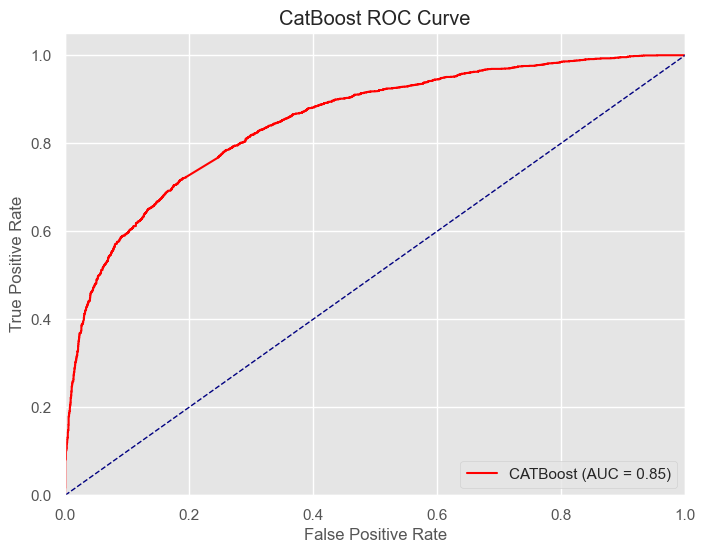

In [29]:
## Import Libraries
plt.style.use("ggplot")
from sklearn.metrics import roc_curve, auc
# ROC Curve for CATBoost
fpr_catboost, tpr_catboost, thresholds_catboost = roc_curve(y_test, y_pred_proba_catboost)
roc_auc_catboost = auc(fpr_catboost, tpr_catboost)

# Plot ROC Curve for each model
plt.figure(figsize=(8, 6))
plt.plot(fpr_catboost, 
         tpr_catboost, 
         color='red', 
         label='CATBoost (AUC = %0.2f)' % roc_auc_catboost)

plt.plot([0, 1], 
         [0, 1], 
         color='navy', 
         lw=1, 
         linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CatBoost ROC Curve')
plt.legend(loc="lower right")
plt.show()


### XGBoost Classifier

##### Grid Search CV with Cross-Validation For XGBoost

In [45]:
### Grid Search CV with Cross-Validation For XGBoost
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Parameters grid for Grid Search
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3], 
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 150, 200] 
}

# Perform Grid Search with Cross-Validation (5 folds)
grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='roc_auc')
grid_result = grid_search.fit(X_train_tfidf, 
                              y_train.values.ravel())

# Get the best parameters and the best score
best_params = grid_result.best_params_
best_score = grid_result.best_score_

print("Best Parameters:", best_params)
print("Best ROC AUC Score:", best_score)


##### Model Building and Evaluation for XGBoost Classifier

In [24]:
# Extreme Gradient Boosting
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import time

# Initialize and fit XGBoost Classifier
xgb_model = xgb.XGBClassifier(n_estimators=400,
                              max_depth=15,
                              learning_rate=0.3)
start = time.time()
xgb_model.fit(X_train_tfidf, y_train.values.ravel())
end = time.time()
fit_time = (end - start)

# Make Predictions
y_pred_xgb = xgb_model.predict(X_test_tfidf)

# Calculate Predict Time
start = time.time()
y_pred_proba_xgb = xgb_model.predict_proba(X_test_tfidf)[:, 1]
end = time.time()
pred_time = (end - start)

# Performance Metrics for XGBoost
precision_xgb, recall_xgb, fscore_xgb, support_xgb = score(y_test,
                                                           y_pred_xgb,
                                                           average="binary")
accuracy_xgb = (y_pred_xgb == y_test["is_sarcastic"]).sum() / len(y_pred_xgb)
print("Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}".format(round(fit_time, 3),
                                                                                              round(pred_time, 3),
                                                                                              round(precision_xgb, 3),
                                                                                              round(recall_xgb, 3),
                                                                                              round(accuracy_xgb, 3)))



##### ROC Curve for XGBoost

In [ ]:
# ROC Curve for XGBoost
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, 
                                             y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, 
                  tpr_xgb)

# Plot ROC Curve for XGBoost
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, 
         tpr_xgb, 
         color = "red", 
         label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)

plt.plot([0, 1], 
         [0, 1], 
         color='navy', 
         lw=1, 
         linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc="lower right");

### Random Forest Classifier


##### Grid Search CV with Cross-Validation For Random Forest

In [23]:
### Grid Search CV with Cross-Validation For Random Forest
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest classifier
rf_model = RandomForestClassifier()

# Parameters grid for Grid Search
param_grid = {
    'n_estimators': [100, 150, 200],  
    'max_depth': [None, 5, 10, 15]
}

# Perform Grid Search with Cross-Validation (5 folds)
grid_search = GridSearchCV(estimator=rf_model, 
                           param_grid=param_grid, 
                           cv=5, scoring='roc_auc', 
                           verbose=0, 
                           n_jobs=-1)
grid_result = grid_search.fit(X_train_tfidf, 
                              y_train.values.ravel())

# Get the best parameters and the best score
best_params = grid_result.best_params_
best_score = grid_result.best_score_

print("Best Parameters:", best_params)
print("Best ROC AUC Score:", best_score)


##### Model Building and Evaluation for Random Forest Classifier

In [ ]:
# #### Exploring Parameter Settings Using GridSearchCV: TF_IDF
# from sklearn.ensemble import RandomForestClassifier 
# from sklearn.model_selection import GridSearchCV    
# rf = RandomForestClassifier()   
# param = {"n_estimators": [10, 150, 300], "max_depth": [30, 60, 90, None]}   
# gs = GridSearchCV(rf, param, cv=5, n_jobs=-1, return_train_score=True)       
# gs_fit = gs.fit(X_train_tfidf, 
#                               y_train.values.ravel())            
# pd.DataFrame(gs_fit.cv_results_).sort_values("mean_test_score", ascending=False)[0:5]       


KeyboardInterrupt: 

In [ ]:

## Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

# Initialize and fit Random Forest Classifier
rf_model = RandomForestClassifier(n_jobs=-1)
start = time.time()
rf_model.fit(X_train_tfidf, y_train.values.ravel())
end = time.time()
fit_time = (end - start)

# Make Predictions
y_pred_rf = rf_model.predict(X_test_tfidf)

# Calculate Predict Time
start = time.time()
y_pred_proba_rf = rf_model.predict_proba(X_test_tfidf)[:, 1]
end = time.time()
pred_time = (end - start)

# Performance Metrics for Random Forest
precision_rf, recall_rf, fscore_rf, support_rf = score(y_test, y_pred_rf, average="binary")
accuracy_rf = (y_pred_rf == y_test["is_sarcastic"]).sum() / len(y_pred_rf)
print("Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}".format(
    round(fit_time, 3), round(pred_time, 3), round(precision_rf, 3), round(recall_rf, 3), round(accuracy_rf, 3)))



Fit time: 34.811 / Predict time: 0.688 ---- Precision: 1.0 / Recall: 0.031 / Accuracy: 0.582


##### ROC Curve for Random Forest

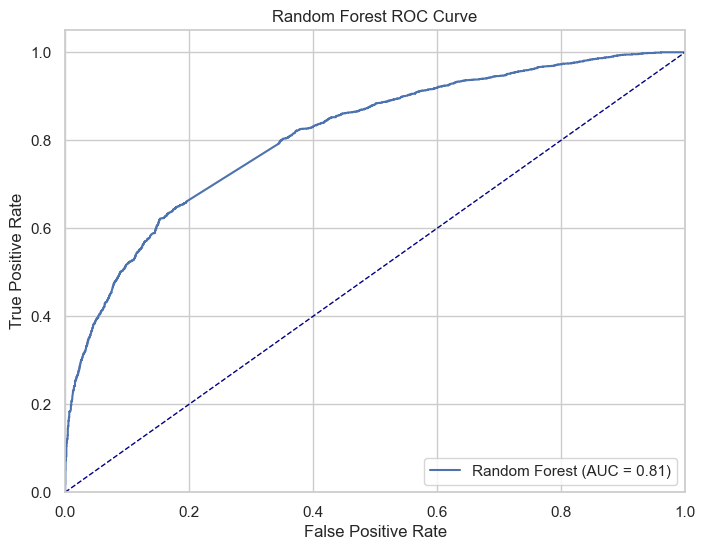

In [ ]:
# ROC Curve for Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC Curve for Random Forest
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc="lower right")
plt.show()


##### Compasrison of the Models

In [ ]:
# Plot ROC Curves for all three models
plt.figure(figsize=(8, 6))
plt.plot(fpr_catboost, tpr_catboost, label='CatBoost (AUC = %0.2f)' % roc_auc_catboost)
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');
plt.title('Comparison of ROC Curves for the Three Models')
plt.legend(loc="lower right")
plt.show()  